In [ ]:
!pip install tensorflow==2.16.2



## LSTM Networks

Long Short-Term Memory (LSTM) networks are a special kind of recurrent neural network (RNN) capable of learning long-term dependencies. They are explicitly designed to avoid the long-term dependency problem. The key to their success lies in their ability to maintain and control the flow of information through a series of gates: the forget gate, the input gate, and the output gate.

![Screenshot 2024-07-07 at 12.23.39 AM.png](<attachment:Screenshot 2024-07-07 at 12.23.39 AM.png>)

#### Forget Gate

**Function**: The forget gate decides what information should be discarded or kept from the cell state.

![Screenshot 2024-07-07 at 12.23.52 AM.png](<attachment:Screenshot 2024-07-07 at 12.23.52 AM.png>)

**Equation**:
\[ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \]

- \( f_t \) is the forget gate vector.
- \( \sigma \) is the sigmoid function, which outputs a value between 0 and 1.
- \( W_f \) is the weight matrix for the forget gate.
- \( h_{t-1} \) is the previous hidden state.
- \( x_t \) is the current input.
- \( b_f \) is the bias for the forget gate.

**Explanation**:
- The forget gate outputs a number between 0 and 1 for each number in the cell state \( C_{t-1} \). A value of 0 means "completely forget" and a value of 1 means "completely keep".
- The forget gate learns what information to discard over time, which helps the network avoid the issue of vanishing gradients by not retaining irrelevant information for too long.

#### Input Gate

**Function**: The input gate decides what new information will be stored in the cell state.

![Screenshot 2024-07-07 at 12.23.59 AM.png](<attachment:Screenshot 2024-07-07 at 12.23.59 AM.png>)

**Equations**:
\[ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \]
\[ \tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) \]

- \( i_t \) is the input gate vector.
- \( \tilde{C}_t \) is the candidate cell state vector.
- \( W_i \) and \( W_C \) are the weight matrices for the input gate and the candidate cell state, respectively.
- \( b_i \) and \( b_C \) are the biases for the input gate and the candidate cell state, respectively.
- \( \tanh \) is the hyperbolic tangent function, which outputs a value between -1 and 1.

**Explanation**:
- The input gate determines which values will be updated in the cell state.
- The candidate cell state \( \tilde{C}_t \) contains the new candidate values that could be added to the cell state.
- The input gate modulates the contribution of the new candidate values to the cell state.

#### Output Gate

**Function**: The output gate decides what part of the cell state will be output as the new hidden state.

![Screenshot 2024-07-07 at 12.24.06 AM.png](<attachment:Screenshot 2024-07-07 at 12.24.06 AM.png>)

**Equation**:
\[ o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \]
\[ h_t = o_t * \tanh(C_t) \]

- \( o_t \) is the output gate vector.
- \( h_t \) is the new hidden state vector.
- \( W_o \) is the weight matrix for the output gate.
- \( b_o \) is the bias for the output gate.

**Explanation**:
- The output gate controls the exposure of the internal state to the outside world.
- The hidden state \( h_t \) is a filtered version of the cell state \( C_t \) passed through a \( \tanh \) activation function, modulated by the output gate \( o_t \).
- The hidden state serves as input to the next time step and is also used in generating the final output of the LSTM.

### The LSTM Cell: Bringing It All Together

**Cell State Update Equation**:
\[ C_t = f_t * C_{t-1} + i_t * \tilde{C}_t \]

- The new cell state \( C_t \) is a combination of the old cell state \( C_{t-1} \) multiplied by the forget gate \( f_t \) and the new candidate cell state \( \tilde{C}_t \) modulated by the input gate \( i_t \).

### Visual Summary

1. **Forget Gate**: Determines what to discard from the previous cell state.
2. **Input Gate**: Decides which new information to add to the cell state.
3. **Output Gate**: Controls the information passed to the hidden state.

### Improvements and Enhancements

1. **Peephole Connections**: Allow gates to also use the cell state, which can enhance performance for certain tasks.
2. **Coupled Forget and Input Gates**: Simplifies the LSTM by coupling the forget and input gates to reduce the number of parameters.
3. **Gated Recurrent Units (GRUs)**: A simpler variant of LSTMs with fewer gates, which can sometimes achieve comparable performance with reduced computational cost.
4. **Attention Mechanisms**: Enhances seq2seq models by allowing them to focus on relevant parts of the input sequence when generating the output, significantly improving performance on tasks requiring long-term dependencies.

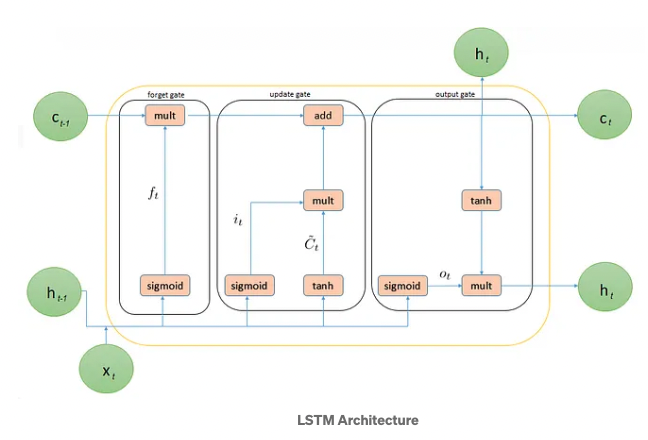
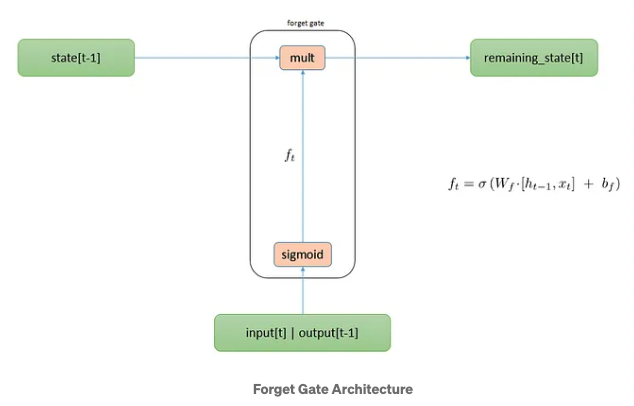
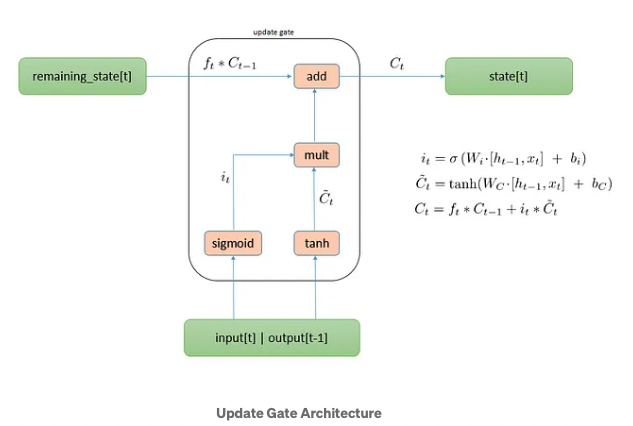
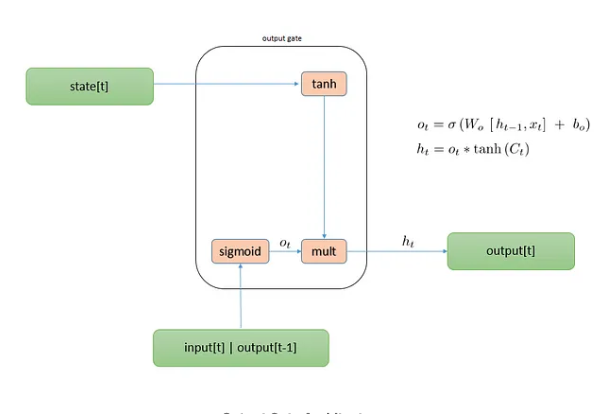

In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, save_model
from nltk.translate.bleu_score import sentence_bleu

In [3]:
data_text  = pd.read_csv('/content/df_commentary_new.csv')

In [4]:
def data_processing(data,number_of_rows, list_of_columns):
    data = data.drop(columns= list_of_columns,axis=1)
    data = data.head(number_of_rows)
    return data

## Tokenization

### What is Tokenization?
Tokenization is the process of converting a text into individual tokens, which are typically words or subwords. This step is essential for transforming textual data into a format that can be processed by machine learning models.

### Why Do We Tokenize?
Tokenization is a critical preprocessing step in NLP because it transforms raw text into a structured format that models can understand. By converting words into numerical tokens, we enable the model to learn and make predictions based on these numerical representations.

### How Can We Improve Tokenization?
- Subword Tokenization: Techniques like Byte Pair Encoding (BPE) or WordPiece can handle out-of-vocabulary (OOV) words by breaking them into subword units. This is particularly useful for dealing with rare or unseen words during training.
- Pre-trained Tokenizers: Using tokenizers pre-trained on large corpora (e.g., BERT or GPT tokenizers) can leverage existing knowledge and improve the quality of tokenization.
Handling Special Characters: Including special tokens for unknown words, padding, and sentence boundaries can provide additional context to the model.

In [5]:
def tokenize(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data['Modified_Commentary'])
    return tokenizer

## Input Sequences and Padding

### What is Padding?
Padding is the process of adding extra tokens to sequences to ensure they all have the same length. This is crucial because neural networks require inputs of uniform size.

### Why Do We Use Padding?
- Uniform Input Size: Neural networks, including LSTMs, require inputs to have a fixed shape. Padding sequences to the same length ensures that the model can process them uniformly.
- Efficient Batch Processing: Padding allows for the efficient processing of sequences in batches, which speeds up training and inference.

### How Can We Improve Padding?
- Dynamic Padding: Instead of padding all sequences to the same length, use dynamic padding within each batch to minimize the amount of padding required. This can reduce computational overhead.
- Masking: Use masking techniques to ignore padded values during training. This ensures that the model focuses only on the meaningful parts of the input sequences.
- Truncation: For excessively long sequences, consider truncating them to a maximum length that balances performance and computational efficiency.

In [6]:
def input_sequences(data):
  input_sequences = []
  for i in range(len(data_text['Modified_Commentary'])):
      text = data_text['Modified_Commentary'][i]
      token_list = tokenizer.texts_to_sequences([text])[0]
      for i in range(1, len(token_list)):
          n_gram_sequence = token_list[:i+1]
          input_sequences.append(n_gram_sequence)

  max_len = max(len(x) for x in input_sequences)

  return input_sequences, max_len


In [7]:
### Calling all the functions

dropped_columns = ['Unnamed: 0']
data_text =  data_processing(data_text, 1000, dropped_columns)
tokenizer  = tokenize(data_text)
input_sequences, max_len = input_sequences(data_text)
padded_input_sequences = pad_sequences(input_sequences, maxlen=max_len + 1, padding='pre')
padded_input_sequences
x = padded_input_sequences[:, :-1]
y = padded_input_sequences[:, -1]
y = to_categorical(y, num_classes=len(tokenizer.word_index)+1)
print('x shape : ',{x.shape})
print('y shape : ',{y.shape})


x shape :  {(45086, 153)}
y shape :  {(45086, 3583)}


In [8]:

# print maximum word index

max_word_index = max([index for word, index in tokenizer.word_index.items()])
print(f"Maximum word index: {max_word_index}")

# print max length each string

max_length = data_text['Modified_Commentary'].str.len().max()

print(f"Maximum length of a string: {max_length}")

max_text_index = data_text[data_text['Modified_Commentary'].str.len() == max_length].index[0]

print(f"Index of maximum length of a string: {max_text_index}")


Maximum word index: 3582
Maximum length of a string: 798
Index of maximum length of a string: 325


## Model Architecture

 - Embedding Layer: Converts token sequences into dense vectors of fixed size. This helps in capturing semantic meaning and reduces the dimensionality of the input space.
 - LSTM Layers: Capture sequential dependencies in the data. The return_sequences=True parameter in the first LSTM layer ensures that the entire sequence is output, which is then fed into the next LSTM layer.
 - Dense Layer: Applies a softmax activation to generate probabilities for the next word in the sequence.

In [9]:
def lstm_model():

  model = Sequential()
  model.add(Embedding(input_dim=3583, output_dim= 100, input_length=max_len))
  model.add(LSTM(100, return_sequences=True)) # Pass return_sequences to LSTM
  model.add(LSTM(100))
  model.add(Dense(3583, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model


In [10]:
model = lstm_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(x,y,epochs=50)

### with 65 percent accuracy

In [16]:
eval_sequences = tokenizer.texts_to_sequences(eval_data['Modified_Commentary'])
max_predict_len = 10

# Function to predict the next n words
def predict_next_n_words(model, tokenizer, seed_text, n_words):
    result = []
    for _ in range(n_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_len, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=1)[0]
        predicted_word = tokenizer.index_word[predicted_index]
        result.append(predicted_word)
        seed_text += ' ' + predicted_word
    return result

# Evaluate the model
reverse_word_index = dict((i, word) for word, i in tokenizer.word_index.items())
for i, seq in enumerate(eval_sequences):
    if len(seq) > 10:
        first_10_words = seq[:10]
    else:
        first_10_words = seq

    first_10_words_text = ' '.join(reverse_word_index.get(word, '?') for word in first_10_words)
    predicted_words = predict_next_n_words(model, tokenizer, first_10_words_text, max_predict_len)
    actual_next_10_words = seq[10:20] if len(seq) > 20 else seq[10:]
    actual_next_10_words_text = ' '.join(reverse_word_index.get(word, '?') for word in actual_next_10_words)

    print(f"Sentence {i+1}:")
    print(f"First 10 words: {first_10_words_text}")
    print(f"Actual next 10 words: {actual_next_10_words_text}")
    print(f"Predicted next 10 words: {' '.join(predicted_words)}")
    print()








Sentence 1:
First 10 words: out caught by uthappa umesh yadav strikes and removes the
Actual next 10 words: big fish he bowled much better compared to his first
Predicted next 10 words: big fish he is in some form alright comes up

Sentence 2:
First 10 words: four that's harsh on the bowler that didn't deserve to
Actual next 10 words: go to the boundary it was banged in short and
Predicted next 10 words: fetch it from batsman who waits with the ball flying

Sentence 3:
First 10 words: four welcome to delhi says iyer shortish and wide outside
Actual next 10 words: off iyer treks back and fiercely cuts it behind square
Predicted next 10 words: off batsman gets inside the line and helps it on

Sentence 4:
First 10 words: out caught by billings zak attack strikes trap set and
Actual next 10 words: trap sprung so batsman's promotion fails lasted for just two
Predicted next 10 words: trap sprung the finger bowler gets a pie out of

Sentence 5:
First 10 words: four that's a gift and batsman a

## with the accuracy of 90 percent

In [23]:
model.fit(x,y,epochs=15)

Epoch 1/15
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8590 - loss: 0.6160
Epoch 2/15
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.8628 - loss: 0.6055
Epoch 3/15
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.8657 - loss: 0.5946
Epoch 4/15
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.8654 - loss: 0.5887
Epoch 5/15
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8686 - loss: 0.5806
Epoch 6/15
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.8734 - loss: 0.5673
Epoch 7/15
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8728 - loss: 0.5694
Epoch 8/15
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.8746 - loss: 0.5541
Epoch 9/15
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.8776 - loss: 0.5539
Epoch 10/15
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8797 - loss: 0.5446
Epoch 11/15
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.8812 - loss: 0.5358
Epoch 12

In [24]:
save_model(model, 'model_lstm_5.keras')

In [27]:
eval_data_1 = data_text.iloc[-10:]

In [28]:
eval_sequences = tokenizer.texts_to_sequences(eval_data_1['Modified_Commentary'])
max_predict_len = 10

# Function to predict the next n words
def predict_next_n_words(model, tokenizer, seed_text, n_words):
    result = []
    for _ in range(n_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_len, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=1)[0]
        predicted_word = tokenizer.index_word[predicted_index]
        result.append(predicted_word)
        seed_text += ' ' + predicted_word
    return result

# Evaluate the model
reverse_word_index = dict((i, word) for word, i in tokenizer.word_index.items())
for i, seq in enumerate(eval_sequences):
    if len(seq) > 10:
        first_10_words = seq[:10]
    else:
        first_10_words = seq

    first_10_words_text = ' '.join(reverse_word_index.get(word, '?') for word in first_10_words)
    predicted_words = predict_next_n_words(model, tokenizer, first_10_words_text, max_predict_len)
    actual_next_10_words = seq[10:20] if len(seq) > 20 else seq[10:]
    actual_next_10_words_text = ' '.join(reverse_word_index.get(word, '?') for word in actual_next_10_words)

    print(f"Sentence {i+1}:")
    print(f"First 10 words: {first_10_words_text}")
    print(f"Actual next 10 words: {actual_next_10_words_text}")
    print(f"Predicted next 10 words: {' '.join(predicted_words)}")
    print()








Sentence 1:
First 10 words: four exquisite he's seeing the cricket ball like a football
Actual next 10 words: all timing he is not trying to hit the leather
Predicted next 10 words: all timing he was scarced for runs wanted to throw

Sentence 2:
First 10 words: four starts with a full toss on leg easy peasy
Actual next 10 words: for batsman he clips it in front of square on
Predicted next 10 words: for batsman he clips it in front of square on

Sentence 3:
First 10 words: 2 runs to long on 50 run stand in the
Actual next 10 words: fifth over a gentle nudge into the leg side followed
Predicted next 10 words: fifth full one in this man didn't deserve the pace

Sentence 4:
First 10 words: out caught by uthappa the umpire took ages to raise
Actual next 10 words: his finger perhaps it looked like he had a look
Predicted next 10 words: his finger perhaps it looked like he had to turn

Sentence 5:
First 10 words: four cheeky delicate and effective uses the slightest of width
Actual next 10 wo

## Evaluation Metrics: Perplexity and BLEU Score

### Perplexity
Perplexity measures how well a probabilistic model predicts a sample. It is calculated as the exponentiation of the entropy of the model. Lower perplexity indicates better predictive performance.

### BLEU Score
The BLEU (Bilingual Evaluation Understudy) score evaluates the quality of machine-generated text by comparing it to reference translations. It calculates the precision of n-grams between the predicted and reference texts.

In [ ]:


def calculate_bleu(reference, hypothesis):
    return sentence_bleu([reference], hypothesis)


## Challenges with Sequence Length and Attention Mechanisms

### Degradation with Longer Sequences
Seq2seq models tend to struggle with longer sequences due to the difficulty in maintaining context over extended inputs. This often leads to degraded performance as the sequence length increases.

### Attention Mechanisms
Attention mechanisms address this issue by allowing the model to focus on relevant parts of the input sequence when generating each part of the output sequence. This significantly improves the performance of seq2seq models on tasks requiring long-term dependencies.

### Introduction to Transformers
Transformers, such as BERT and GPT, have revolutionized NLP by using self-attention mechanisms to capture global dependencies in sequences. These models have set new benchmarks in various NLP tasks, including translation and text generation.

### State-of-the-Art Models
Models like T5, GPT-3, and BERT are currently state-of-the-art in many NLP tasks. They leverage transformers' capabilities to handle complex language understanding and generation tasks efficiently.

